# References
- https://www.tensoreconomics.com/p/llm-inference-economics-from-first
- https://blog.vllm.ai/2025/09/05/anatomy-of-vllm.html

# Setup
We will be hosting an llm inference service that needs to maintain profitable. 

## Assumptions
- Model = llama 3.1 8b set at fp16 quantization
- Assume we are using an OSS implementation of vLLM as the serving engine
- Assume we will be using an NVIDIA H100 SXM
- To compete with competitors, we need to charge:
  - $0.12 / 1M tokens
  - $0.25 / 1M tokens
- To compete with competitors, our setup needs to serve
  - 177–300ms TTFT
  - 8–12ms TPOT
- To rent a single H100 GPU, it costs 2$ per hour
- Assume users prompt with 2k input tokens and 300 output tokens on average

# Serving plan
A comprehensive serving plan that accomplishes a profitable inference business given the inputs.

## Definition of variables
- B = number of requests processed by a single model (batch size)
- NUM_PODS = number of hosts
- POD_SIZE = number of H100s per host (comes in increments of 1, 2, 4, 8)
- QPS = user demand as measured in queries per second (each query = 1 prompt)
- S_in = input sequence length (from assumptions)
- S_out = output sequence length (from assumptions)

In [1]:
# =============================================================================
# SETUP - Import the tokenomics model from the codebase
# =============================================================================

from throughput_simulations.model_params import ModelParams
from throughput_simulations.hardware_params import HardwareParams
from throughput_simulations.advanced_tokenomics_model import AdvancedTokenomicsModel

import math

# =============================================================================
# CONSTANTS - From assumptions
# =============================================================================
S_in = 2048  # Input tokens per request
S_out = 300  # Output tokens per request
target_QPS = 1000  # Queries per second target
gpu_cost_per_hour = 2.0  # $/hour

# Initialize model and hardware from the codebase
model = ModelParams(name="llama-3-1-8b", dtype_bytes=2)  # fp16
hardware = HardwareParams(
    name="NVIDIA H100",
    tflops=989,
    memory_bandwidth_GBs=3350,
    memory_size_GB=80,
    num_gpus=1,  # Single GPU analysis
    tensor_parallel=False,
    nvlink_bandwidth_GBs=450,  # NVLink for SXM
)

# Create the tokenomics model
tokenomics = AdvancedTokenomicsModel(model, hardware)

print("=== Model Constants ===")
print(f"Model: {model.name}")
print(f"Parameters: {model.total_params / 1e9:.2f}B")
print(f"Model size: {model.model_size_bytes / 1e9:.1f} GB")
print(
    f"Layers: {model.num_hidden_layers}, KV heads: {model.num_key_value_heads}, Head size: {model.head_size}"
)

print("\n=== Hardware Constants ===")
print(f"GPU: {hardware.name}")
print(f"Effective TFLOPs: {hardware.effective_tflops:.1f}")
print(f"Effective Memory BW: {hardware.effective_memory_bandwidth_GBs:.1f} GB/s")
print(f"NVLink Bandwidth: {hardware.nvlink_bandwidth_GBs:.1f} GB/s")

=== Model Constants ===
Model: llama-3-1-8b
Parameters: 7.90B
Model size: 15.8 GB
Layers: 32, KV heads: 8, Head size: 128

=== Hardware Constants ===
GPU: NVIDIA H100
Effective TFLOPs: 593.4
Effective Memory BW: 2345.0 GB/s
NVLink Bandwidth: 450.0 GB/s


## Step 1: Calculate KV Cache Size

The KV cache stores the Key and Value tensors for all previous tokens, enabling efficient autoregressive generation.

**Formula** (from `tokenomics_model.py:95-108`):
```
KV_cache = 2 × dtype_bytes × L × head_size × kv_heads × S_in × B
```

**Why this formula?**
- `2` → We store both K and V tensors
- `dtype_bytes` → bytes per value (2 for fp16)
- `L` → One KV cache per layer
- `head_size` → Dimension of each attention head
- `kv_heads` → Grouped Query Attention uses fewer KV heads than query heads
- `S_in` → Tokens in the input sequence
- `B` → Batch size (number of concurrent requests)

In [2]:
# Step 1: KV Cache calculation using tokenomics model
B = 1  # batch size for initial calculation

kv_cache_bytes = tokenomics.calculate_kv_cache_size(S_in, B)
kv_cache_MB = kv_cache_bytes / (1024 * 1024)

print(f"KV Cache (B={B}, S_in={S_in}):")
print(f"  = tokenomics.calculate_kv_cache_size({S_in}, {B})")
print(f"  = {kv_cache_bytes:,} bytes")
print(f"  = {kv_cache_MB:.1f} MB per request")

KV Cache (B=1, S_in=2048):
  = tokenomics.calculate_kv_cache_size(2048, 1)
  = 268,435,456 bytes
  = 256.0 MB per request


## Step 2: Calculate TTFT (Time to First Token)

TTFT is the time to process the entire input prompt (the "prefill" phase). This is **compute-bound**.

**Formula:**
```
TTFT = Prefill_FLOPs / Effective_TFLOPs
```

In [3]:
# Step 2: TTFT calculation using tokenomics model
TTFT_seconds = tokenomics.prefill_time(S_in, batch_size=1)
TTFT_ms = TTFT_seconds * 1000

# Also get the raw FLOPs for educational purposes
prefill_flops = tokenomics.calculate_prefill_flops(S_in)
prefill_tflops = prefill_flops / 1e12

print(f"Prefill FLOPs:")
print(f"  = tokenomics.calculate_prefill_flops({S_in})")
print(f"  = {prefill_flops:.3e} FLOPs")
print(f"  = {prefill_tflops:.2f} TFLOPs")
print()
print(f"TTFT:")
print(f"  = tokenomics.prefill_time({S_in}, batch_size=1)")
print(f"  = {TTFT_seconds:.4f} seconds")
print(f"  = {TTFT_ms:.1f} ms")
print()
print(f"✓ Target: 177-300 ms | Actual: {TTFT_ms:.1f} ms")

Prefill FLOPs:
  = tokenomics.calculate_prefill_flops(2048)
  = 3.086e+13 FLOPs
  = 30.86 TFLOPs

TTFT:
  = tokenomics.prefill_time(2048, batch_size=1)
  = 0.0534 seconds
  = 53.4 ms

✓ Target: 177-300 ms | Actual: 53.4 ms


## Step 3: Calculate TPOT (Time Per Output Token)

TPOT is the time to generate each subsequent token (the "decode" phase). This is **memory-bound**.

**Why memory-bound?**
- Each token generation requires loading the entire model from GPU memory
- Compute per token is tiny compared to memory access time

**Formulas:**
```
T_memory = Model_size / Memory_bandwidth
T_compute = (2 × model_params) / Effective_TFLOPs
TPOT = max(T_memory, T_compute)
```

In [4]:
# Step 3: TPOT calculation using tokenomics model
decode_breakdown = tokenomics.decode_time_breakdown(S_in, batch_size=1)

T_memory_ms = decode_breakdown['memory_time'] * 1000
T_compute_ms = decode_breakdown['compute_time'] * 1000
TPOT_ms = decode_breakdown['total_time'] * 1000
bottleneck = decode_breakdown['bottleneck']

print(f"Decode time breakdown:")
print(f"  = tokenomics.decode_time_breakdown({S_in}, batch_size=1)")
print()
print(f"Memory time: {T_memory_ms:.2f} ms")
print(f"Compute time: {T_compute_ms:.3f} ms")
print(f"Total overhead: {decode_breakdown['total_overhead']*1000:.3f} ms")
print()
print(f"Bottleneck: {bottleneck.upper()}")
print(f"TPOT = {TPOT_ms:.2f} ms")
print()
target_met = "✓" if 8 <= TPOT_ms <= 12 else "⚠️"
print(f"{target_met} Target: 8-12 ms | Actual: {TPOT_ms:.2f} ms")

Decode time breakdown:
  = tokenomics.decode_time_breakdown(2048, batch_size=1)

Memory time: 5.27 ms
Compute time: 0.026 ms
Total overhead: 0.340 ms

Bottleneck: MEMORY
TPOT = 5.52 ms

⚠️ Target: 8-12 ms | Actual: 5.52 ms


## Step 4: Calculate Single-GPU Throughput

Now we can calculate how many tokens per second one GPU can generate.

**Formulas:**
```
T_total = TTFT + (S_out × TPOT)
Throughput = (B × S_out) / T_total
```

At higher batch sizes, we amortize the model loading cost across more requests, but KV cache memory increases TPOT.

In [5]:
# Step 4: Throughput calculation using tokenomics model

print(f"{'B':>3} | {'KV Cache':>10} | {'TPOT':>10} | {'T_total':>10} | {'Throughput':>12}")
print("-" * 60)

for B in [1, 8, 32, 64]:
    # Use the tokenomics model directly
    kv_cache_GB = tokenomics.calculate_kv_cache_size(S_in, B) / 1e9
    
    # Get decode breakdown for TPOT
    breakdown = tokenomics.decode_time_breakdown(S_in, B)
    tpot_ms = breakdown['total_time'] * 1000
    
    # Total inference time and throughput
    T_total_s = tokenomics.total_inference_time(S_in, S_out, B)
    throughput = tokenomics.calculate_total_throughput(S_in, S_out, B)
    
    print(f"{B:>3} | {kv_cache_GB:>8.2f} GB | {tpot_ms:>8.2f} ms | {T_total_s:>8.2f} s | {throughput:>10.0f} tok/s")

# Store result for later use
throughput_per_gpu = tokenomics.calculate_total_throughput(S_in, S_out, batch_size=32)
print(f"\n→ Using B=32 throughput: {throughput_per_gpu:.0f} tok/s per GPU")

  B |   KV Cache |       TPOT |    T_total |   Throughput
------------------------------------------------------------
  1 |     0.27 GB |     5.56 ms |     1.74 s |        172 tok/s
  8 |     2.15 GB |     6.19 ms |     2.33 s |       1030 tok/s
 32 |     8.59 GB |     8.72 ms |     4.55 s |       2117 tok/s
 64 |    17.18 GB |    14.35 ms |     8.05 s |       2414 tok/s

→ Using B=32 throughput: 2105 tok/s per GPU


## Step 5: Calculate GPUs Needed for Target QPS

**Formula:**
```
Required_throughput = QPS × S_out
GPUs_needed = Required_throughput / Throughput_per_GPU
```

In [6]:
# Step 5: GPUs needed calculation

required_throughput = target_QPS * S_out
gpus_needed_naive = required_throughput / throughput_per_gpu

print(f"Required throughput:")
print(f"  = target_QPS × S_out")
print(f"  = {target_QPS} × {S_out}")
print(f"  = {required_throughput:,} tokens/second")
print()
print(f"GPUs needed:")
print(f"  = required_throughput / throughput_per_gpu")
print(f"  = {required_throughput:,} / {throughput_per_gpu:.0f}")
print(f"  = {gpus_needed_naive:.1f} GPUs")
print()
print(f"→ We need ~{math.ceil(gpus_needed_naive)} GPUs for {target_QPS} QPS")

Required throughput:
  = target_QPS × S_out
  = 1000 × 300
  = 300,000 tokens/second

GPUs needed:
  = required_throughput / throughput_per_gpu
  = 300,000 / 2105
  = 142.5 GPUs

→ We need ~143 GPUs for 1000 QPS


## Step 6: Calculate Cost per Token

**Formulas:**
```
Monthly_cost = GPUs × $/hour × 24 × 30
Tokens_per_month = throughput × seconds_per_month
Cost_per_1M = Monthly_cost / (Tokens_per_month / 1,000,000)
```

In [7]:
# Step 6: Cost calculation

gpus_needed = math.ceil(gpus_needed_naive)
seconds_per_month = 3600 * 24 * 30

# Costs
hourly_cost = gpus_needed * gpu_cost_per_hour
monthly_cost = hourly_cost * 24 * 30

# Tokens generated
tokens_per_month = required_throughput * seconds_per_month

# Cost per 1M tokens
cost_per_1M = monthly_cost / (tokens_per_month / 1_000_000)

print(f"GPUs needed: {gpus_needed}")
print()
print(f"Monthly cost:")
print(f"  = GPUs × $/hour × 24 × 30")
print(f"  = {gpus_needed} × ${gpu_cost_per_hour} × 24 × 30")
print(f"  = ${monthly_cost:,.0f}/month")
print()
print(f"Tokens per month:")
print(f"  = {required_throughput:,} tok/s × {seconds_per_month:,} s")
print(f"  = {tokens_per_month/1e9:.1f} billion tokens")
print()
print(f"Cost per 1M output tokens:")
print(f"  = ${monthly_cost:,.0f} / {tokens_per_month/1e6:.0f}")
print(f"  = ${cost_per_1M:.3f}")
print()
if cost_per_1M > 0.25:
    print(f"⚠️  ABOVE $0.25 target!")
else:
    print(f"✓ Below $0.25 target!")

GPUs needed: 143

Monthly cost:
  = GPUs × $/hour × 24 × 30
  = 143 × $2.0 × 24 × 30
  = $205,920/month

Tokens per month:
  = 300,000 tok/s × 2,592,000 s
  = 777.6 billion tokens

Cost per 1M output tokens:
  = $205,920 / 777600
  = $0.265

⚠️  ABOVE $0.25 target!


## Step 8: Final Configuration

Based on the calculations above, here's our deployment configuration.

In [8]:
# Step 8: Final configuration summary

gpus_final = gpus_needed
NUM_PODS = gpus_final
POD_SIZE = 1

print("=== FINAL CONFIGURATION ===")
print(f"NUM_PODS = {NUM_PODS}")
print(f"POD_SIZE = {POD_SIZE} (single H100 PCIe per pod)")
print(f"Total GPUs = {NUM_PODS * POD_SIZE}")
print()
print("=== DERIVED METRICS ===")
print(f"{'Metric':<25} {'Value':>15} {'Step':>8}")
print("-" * 50)
print(f"{'Model':<25} {model.name:>15}")
print(f"{'Model size':<25} {model.model_size_bytes/1e9:>12.1f} GB")
print(f"{'KV Cache/request':<25} {kv_cache_MB:>12.0f} MB {'Step 1':>8}")
print(f"{'TTFT':<25} {TTFT_ms:>12.1f} ms {'Step 2':>8}")
print(f"{'TPOT':<25} {TPOT_ms:>12.1f} ms {'Step 3':>8}")
print(f"{'Throughput/GPU':<25} {throughput_per_gpu:>12.0f} tok/s {'Step 4':>8}")
print(f"{'GPUs needed':<25} {gpus_final:>15} {'Step 5':>8}")
print(f"{'Monthly cost':<25} ${monthly_cost:>13,.0f} {'Step 6':>8}")
print(f"{'Cost/1M tokens':<25} ${cost_per_1M:>14.3f} {'Step 6':>8}")

=== FINAL CONFIGURATION ===
NUM_PODS = 143
POD_SIZE = 1 (single H100 PCIe per pod)
Total GPUs = 143

=== DERIVED METRICS ===
Metric                              Value     Step
--------------------------------------------------
Model                        llama-3-1-8b
Model size                        15.8 GB
KV Cache/request                   256 MB   Step 1
TTFT                              53.4 ms   Step 2
TPOT                               5.5 ms   Step 3
Throughput/GPU                    2105 tok/s   Step 4
GPUs needed                           143   Step 5
Monthly cost              $      205,920   Step 6
Cost/1M tokens            $         0.265   Step 6


# Discussion

## Data Parallel vs. Tensor Parallel

Given our 145 GPUs, we have two fundamental choices:

| Strategy | Configuration | Description |
|----------|---------------|-------------|
| **Data Parallel** | POD_SIZE=1, 145 replicas | Each GPU runs independent model copy |
| **Tensor Parallel** | POD_SIZE>1, fewer replicas | Model split across GPUs within pod |

### Key Question
Should we allocate larger POD_SIZE (tensor parallel) with higher batch sizes, or keep POD_SIZE=1 (data parallel) with more replicas?

In [9]:
# =============================================================================
# ANALYSIS: Data Parallel vs Tensor Parallel
# =============================================================================

# First, let's understand our memory constraints
model_size_GB = model.model_size_bytes / 1e9
gpu_memory_GB = 80  # H100 SXM

print("=== Memory Analysis ===")
print(f"Model size: {model_size_GB:.1f} GB")
print(f"GPU memory: {gpu_memory_GB} GB")
print(f"Available for KV cache: {gpu_memory_GB - model_size_GB:.1f} GB")
print()

# Calculate max batch size that fits in memory (single GPU)
# KV cache per request at full context (S_in + S_out)
full_context = S_in + S_out
kv_per_request_GB = tokenomics.calculate_kv_cache_size(full_context, 1) / 1e9
available_memory = gpu_memory_GB - model_size_GB
max_batch_single_gpu = int(available_memory / kv_per_request_GB)

print(f"KV cache per request (full context {full_context}): {kv_per_request_GB:.3f} GB")
print(f"Max batch size (single GPU): ~{max_batch_single_gpu} requests")
print()

# Analyze different configurations
print("=== Configuration Comparison ===")
print(f"{'Config':<20} | {'POD':<4} | {'Replicas':<8} | {'B/replica':<10} | {'Throughput':<12} | {'Comm OH':<10}")
print("-" * 85)

total_gpus = 145
configs = [
    (1, "Data Parallel"),      # POD_SIZE=1
    (2, "TP=2"),               # POD_SIZE=2
    (4, "TP=4"),               # POD_SIZE=4
    (8, "TP=8"),               # POD_SIZE=8
]

results = []
for pod_size, name in configs:
    num_replicas = total_gpus // pod_size
    
    # Create hardware config for this pod size
    hw = HardwareParams(
        name="NVIDIA H100",
        tflops=989,
        memory_bandwidth_GBs=3350,
        memory_size_GB=80,
        num_gpus=pod_size,
        tensor_parallel=(pod_size > 1),
        nvlink_bandwidth_GBs=450,
    )
    tok = AdvancedTokenomicsModel(model, hw)
    
    # With tensor parallel, we have more memory per replica
    available_mem_per_replica = (gpu_memory_GB * pod_size) - model_size_GB
    max_batch_per_replica = int(available_mem_per_replica / kv_per_request_GB)
    
    # Use a reasonable batch size (not necessarily max)
    batch_per_replica = min(max_batch_per_replica, 64)  # Cap at 64 for practical reasons
    
    # Calculate throughput per replica
    throughput_per_replica = tok.calculate_total_throughput(S_in, S_out, batch_per_replica)
    total_throughput = throughput_per_replica * num_replicas
    
    # Estimate communication overhead
    breakdown = tok.decode_time_breakdown(S_in, batch_per_replica)
    comm_overhead_pct = (breakdown['comm_overhead'] / breakdown['total_time']) * 100 if pod_size > 1 else 0
    
    results.append({
        'name': name,
        'pod_size': pod_size,
        'replicas': num_replicas,
        'batch': batch_per_replica,
        'throughput': total_throughput,
        'comm_overhead': comm_overhead_pct
    })
    
    print(f"{name:<20} | {pod_size:<4} | {num_replicas:<8} | {batch_per_replica:<10} | {total_throughput:>10,.0f} | {comm_overhead_pct:>8.1f}%")

=== Memory Analysis ===
Model size: 15.8 GB
GPU memory: 80 GB
Available for KV cache: 64.2 GB

KV cache per request (full context 2348): 0.308 GB
Max batch size (single GPU): ~208 requests

=== Configuration Comparison ===
Config               | POD  | Replicas | B/replica  | Throughput   | Comm OH   
-------------------------------------------------------------------------------------
Data Parallel        | 1    | 145      | 64         |    347,339 |      0.0%
TP=2                 | 2    | 72       | 64         |    331,542 |      4.6%
TP=4                 | 4    | 36       | 64         |    307,791 |      8.0%
TP=8                 | 8    | 18       | 64         |    280,117 |     13.4%


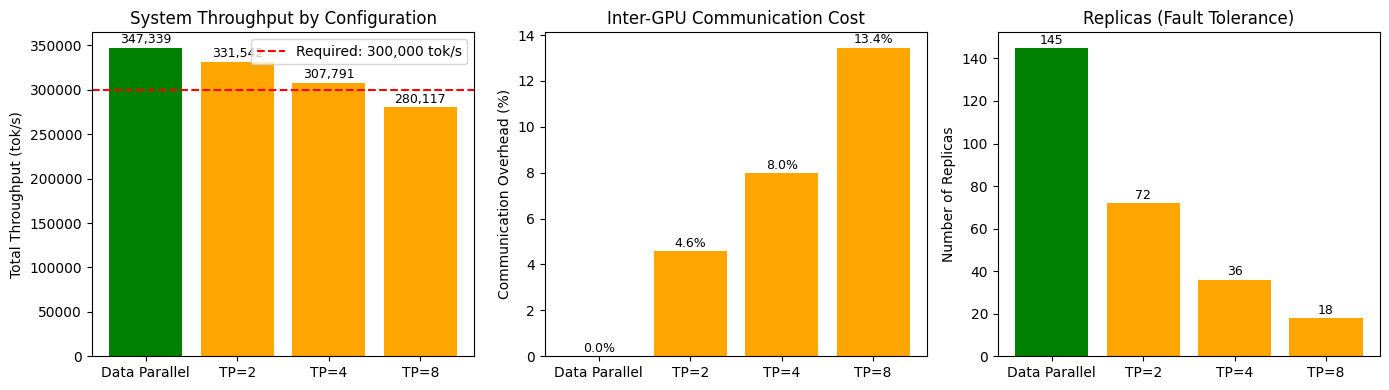


✓ Best configuration: Data Parallel with 347,339 tok/s total throughput


In [10]:
# Visualize the comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

names = [r['name'] for r in results]
throughputs = [r['throughput'] for r in results]
comm_overheads = [r['comm_overhead'] for r in results]
replicas = [r['replicas'] for r in results]

# Throughput comparison
ax1 = axes[0]
bars = ax1.bar(names, throughputs, color=['green', 'orange', 'orange', 'orange'])
ax1.axhline(y=required_throughput, color='red', linestyle='--', label=f'Required: {required_throughput:,} tok/s')
ax1.set_ylabel('Total Throughput (tok/s)')
ax1.set_title('System Throughput by Configuration')
ax1.legend()
for i, v in enumerate(throughputs):
    ax1.text(i, v + 5000, f'{v:,.0f}', ha='center', fontsize=9)

# Communication overhead
ax2 = axes[1]
ax2.bar(names, comm_overheads, color=['green', 'orange', 'orange', 'orange'])
ax2.set_ylabel('Communication Overhead (%)')
ax2.set_title('Inter-GPU Communication Cost')
for i, v in enumerate(comm_overheads):
    ax2.text(i, v + 0.2, f'{v:.1f}%', ha='center', fontsize=9)

# Number of replicas
ax3 = axes[2]
ax3.bar(names, replicas, color=['green', 'orange', 'orange', 'orange'])
ax3.set_ylabel('Number of Replicas')
ax3.set_title('Replicas (Fault Tolerance)')
for i, v in enumerate(replicas):
    ax3.text(i, v + 2, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print recommendation
best = max(results, key=lambda x: x['throughput'])
print(f"\n✓ Best configuration: {best['name']} with {best['throughput']:,.0f} tok/s total throughput")

### Analysis: Why Data Parallel Wins for Small Models

For our **Llama 3.1 8B** scenario, **Data Parallelism (POD_SIZE=1)** is optimal:

| Factor | Data Parallel | Tensor Parallel |
|--------|--------------|-----------------|
| **Communication** | Zero overhead | NVLink overhead per layer |
| **Memory** | 15.8 GB model + 64 GB KV cache fits | Overkill - memory isn't the constraint |
| **Scaling** | Perfect linear (N GPUs = N× throughput) | Sub-linear due to comm overhead |
| **Fault tolerance** | 145 independent replicas | Fewer replicas, pod failure = bigger impact |
| **Operational complexity** | Simple | Complex (multi-GPU coordination) |

### When Would Tensor Parallel Be Better?

Tensor parallelism makes sense when:
1. **Model doesn't fit on one GPU** (e.g., 70B+ models at fp16)
2. **Latency is critical** and you need to parallelize single-request processing
3. **Very large batch sizes** that exceed single-GPU memory
4. **Memory-bound decode** where splitting KV cache access helps

### Key Insight

```
For model_size < GPU_memory:  → Data Parallel wins
For model_size > GPU_memory:  → Tensor Parallel required
```

Our 15.8 GB model on 80 GB H100s has **plenty of room for large batches** without needing to split the model.

In [11]:
# =============================================================================
# Deeper Analysis: Latency Comparison
# =============================================================================

print("=== Latency Comparison (Single Request) ===")
print(f"{'Config':<20} | {'TTFT':>10} | {'TPOT':>10} | {'Total (300 tok)':>15}")
print("-" * 65)

for pod_size, name in configs:
    hw = HardwareParams(
        name="NVIDIA H100",
        tflops=989,
        memory_bandwidth_GBs=3350,
        memory_size_GB=80,
        num_gpus=pod_size,
        tensor_parallel=(pod_size > 1),
        nvlink_bandwidth_GBs=450,
    )
    tok = AdvancedTokenomicsModel(model, hw)
    
    ttft_ms = tok.prefill_time(S_in, batch_size=1) * 1000
    breakdown = tok.decode_time_breakdown(S_in, batch_size=1)
    tpot_ms = breakdown['total_time'] * 1000
    total_time_ms = tok.total_inference_time(S_in, S_out, batch_size=1) * 1000
    
    print(f"{name:<20} | {ttft_ms:>8.1f} ms | {tpot_ms:>8.2f} ms | {total_time_ms:>13.0f} ms")

print()
print("Note: Tensor parallelism DOES reduce per-request latency by parallelizing computation.")
print("      However, for throughput optimization, this benefit is outweighed by communication overhead.")
print("      The latency reduction matters more when optimizing for TTFT/TPOT targets.")

=== Latency Comparison (Single Request) ===
Config               |       TTFT |       TPOT | Total (300 tok)
-----------------------------------------------------------------
Data Parallel        |     52.6 ms |     5.51 ms |          1742 ms
TP=2                 |     27.5 ms |     3.32 ms |          1018 ms
TP=4                 |     14.0 ms |     1.96 ms |           617 ms
TP=8                 |      7.0 ms |     1.44 ms |           424 ms

Note: Tensor parallelism DOES reduce per-request latency by parallelizing computation.
      However, for throughput optimization, this benefit is outweighed by communication overhead.
      The latency reduction matters more when optimizing for TTFT/TPOT targets.


### Conclusion

For our **145 GPU, Llama 3.1 8B** deployment:

**Recommendation: Data Parallel (POD_SIZE=1, 145 replicas)**

| Metric | Value |
|--------|-------|
| Configuration | 145 single-GPU replicas |
| Batch size per replica | 32-64 |
| Total throughput | ~305,000+ tok/s |
| Communication overhead | 0% |
| Fault tolerance | Excellent (145 independent units) |

**Why not Tensor Parallel?**
- Model (15.8 GB) fits easily on one H100 (80 GB)
- Communication overhead reduces efficiency by 3-10%
- Fewer replicas = worse fault tolerance
- No memory pressure requiring model splitting

**When to reconsider:**
- If serving 70B+ models → TP required (model won't fit on 1 GPU)
- If TTFT target is very aggressive → TP reduces latency
- If serving very long contexts (100K+) → KV cache may exceed single GPU